# Photometric Analysis
Using the reduced data from leuschner, get differential aperture photometry on your source (or at least one known star) in at least 1 image.  If you can, do this for both B & V and give the B-V color.  Compare this to values from literature.

In [283]:
import sys
#myLibPaths = [r'/home/bizard/astronomy/python', r'/home/bizard/astronomy/teaching/ASTR 470 - Obs Astro/2021_Spring/coding']
#for libPath in myLibPaths:
#    if (libPath not in sys.path):
#        sys.path.insert(0,libPath)

In [284]:
import os
import re
import numpy as np
import re

In [285]:
from matplotlib import pyplot as plt

%matplotlib inline

In [286]:
from astropy import units as u

from astropy.visualization import (
    hist,
    SqrtStretch,
    LogStretch,
    LinearStretch,
    PercentileInterval,
    AsymmetricPercentileInterval,
    MinMaxInterval,
)
from astropy.visualization.mpl_normalize import ImageNormalize
from matplotlib.colors import LogNorm
from astropy.stats import sigma_clipped_stats

from astropy.nddata import CCDData
from astropy.io import fits

In [287]:
from photutils import (
    DAOStarFinder,
    CircularAperture,
    CircularAnnulus
)

# Define Directory Paths

In [288]:
sciencedir = r'./Leuschner Observing Script/20210304'

ignore_file = re.compile('(median|average|ignore|test|focus)')
bias_pat = re.compile('[bB]ias_[0-9]{1,2}.fits')
dark_pat = re.compile('[dD]ark_([0-9]{1,3})s_[0-9]{1,2}(_debiased.fits|.fits)')
flat_pat = re.compile('[fF]lat_([UBVRIubvri]{1})_[0-9]{1,2}.fits')

# The science files are all of the ones we aren't ignoring *and* 
# aren't one of the calibration files.
#
science_files = [os.path.join(sciencedir,f) for f in os.listdir(sciencedir) if 
                 (f.endswith('.fits') and 
                  (not ignore_file.search(f)) and
                  (not bias_pat.search(f)) and
                  (not dark_pat.search(f)) and
                  (not flat_pat.search(f))
                 ) ]

In [289]:
science_files

['./Leuschner Observing Script/20210304/BD+25604_V_10s.fits',
 './Leuschner Observing Script/20210304/HD23339_V_10s.fits',
 './Leuschner Observing Script/20210304/SAO56175_B_10s.fits',
 './Leuschner Observing Script/20210304/HD278265_B_10s.fits',
 './Leuschner Observing Script/20210304/TYC288725561_V_20s.fits',
 './Leuschner Observing Script/20210304/VMM_Per_V_20s.fits',
 './Leuschner Observing Script/20210304/BD+25604_B_30s.fits',
 './Leuschner Observing Script/20210304/BD+51811_V_10s.fits',
 './Leuschner Observing Script/20210304/SAO56175_V_10s.fits',
 './Leuschner Observing Script/20210304/HD278265_V_10s.fits',
 './Leuschner Observing Script/20210304/V991_tauri_B_20s.fits',
 './Leuschner Observing Script/20210304/16tau_B_0.5s.fits',
 './Leuschner Observing Script/20210304/HD283172_B_60s.fits',
 './Leuschner Observing Script/20210304/HD275115_B_30s.fits',
 './Leuschner Observing Script/20210304/HD284174_B_30s.fits',
 './Leuschner Observing Script/20210304/HD16209_V_20s.fits',
 './Leu

In [290]:
myStar = 'HD275115'
obs_pat = re.compile('{}_([BV]{{1}})_([0-9]{{1,3}})s.fits'.format(myStar))

obs = [o for o in science_files if obs_pat.search(o)]
obs

['./Leuschner Observing Script/20210304/HD275115_B_30s.fits',
 './Leuschner Observing Script/20210304/HD275115_V_30s.fits']

# Load in 1 image

In [291]:
ccd = CCDData.read(obs[1],unit='adu')
data = ccd.data
hdr = ccd.header

ccd_B = CCDData.read(obs[0],unit='adu')
data_B = ccd_B.data
hdr_B = ccd_B.header

mean, median, std = sigma_clipped_stats(data,sigma=5.0)
print("Mean: {:.1f}, Median: {:.1f}, Std Dev: {:.1f}".format(mean,median,std))

mean_B, median_B, std_B = sigma_clipped_stats(data_B,sigma=5.0)
print("Mean: {:.1f}, Median: {:.1f}, Std Dev: {:.1f}".format(mean_B,median_B,std_B))

Mean: 805.6, Median: 814.0, Std Dev: 44.1
Mean: 739.0, Median: 746.0, Std Dev: 40.6


## Find the sources in the image using DAOFind

In [318]:
fwhm = 12.0 # Found using the 'Optimize Aperture' notebook

In [319]:
daofind = DAOStarFinder(fwhm=fwhm, threshold=5.*std)
sources = daofind(data - median)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id xcentroid ycentroid sharpness  ... sky  peak    flux        mag     
--- --------- --------- ---------- ... --- ----- --------- -------------
  1 360.90816 2.1913521 0.53680405 ...   0   319 5.8202055    -1.9123458
  2 1469.0448 6.4620251 0.50134552 ...   0  3154 47.059103    -4.1816091
  3 1546.8353 30.582896 0.49290229 ...   0    25 1.6891962   -0.56920021
  4 570.27108 84.047197  0.5764075 ...   0   111 2.5176238    -1.0024771
  5 227.62156 135.27659 0.26643008 ...   0   -23 1.0865733   -0.09014757
  6 512.10019 157.82546  0.5023344 ...   0 52830 745.49996    -7.1811191
  7 1102.7014 163.71686  0.2539627 ...   0   -28 1.0086023 -0.0092998418
  8 871.26036 172.79355 0.62718399 ...   0    27 1.0638486  -0.067199571
  9 1432.6755 194.93327 0.45568036 ...   0    52 1.5771557   -0.49468642
 10  1967.114 205.06922 0.64414263 ...   0    78 2.0930337   -0.80194056
...       ...       ...        ... ... ...   ...       ...           ...
 49   1097.27 1059.7989 0.51229881 ...   0  1769  2

In [320]:
sources_B = daofind(data_B - median_B)
for col in sources_B.colnames:
    sources_B[col].info.format = '%.8g'  # for consistent table output
print(sources_B)

 id xcentroid ycentroid  sharpness  ... sky  peak    flux       mag     
--- --------- ---------- ---------- ... --- ----- --------- ------------
  1 1888.7305 -6.3890021 0.51365742 ...   0     4 1.0629021 -0.066233187
  2 1526.5874  5.4594409 0.93302559 ...   0   101 1.8910727  -0.69177057
  3 254.57035  9.9539959 0.78878669 ...   0   371 5.4943536   -1.8497915
  4  1362.576  14.377348 0.72655903 ...   0  3228 42.024093   -4.0587459
  5  1440.133   38.30616 0.63251264 ...   0    69 2.0864876  -0.79853954
  6  463.8659  92.207911 0.69072172 ...   0    66  1.793897  -0.63449374
  7 1436.0299   110.0619 0.24001226 ...   0   -34 1.1323734  -0.13497413
  8 121.52312  143.01362 0.83074422 ...   0    25 1.0993213  -0.10281163
  9 405.58523  165.92845 0.46764405 ...   0 61488 1051.4265   -7.5544472
 10  764.4955  180.69389 0.55428003 ...   0    25 1.2164174  -0.21270657
...       ...        ...        ... ... ...   ...       ...          ...
 47 1717.2587  1038.2392 0.61842775 ...   0   511 7

## Plot up the identified sources to see how it did

In [321]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=12.)

annulus_apertures = CircularAnnulus(positions, r_in=16, r_out=22)
annulus_masks = annulus_apertures.to_mask(method='center')

norm = ImageNormalize(interval=AsymmetricPercentileInterval(0,85), stretch=LinearStretch(),clip=True)

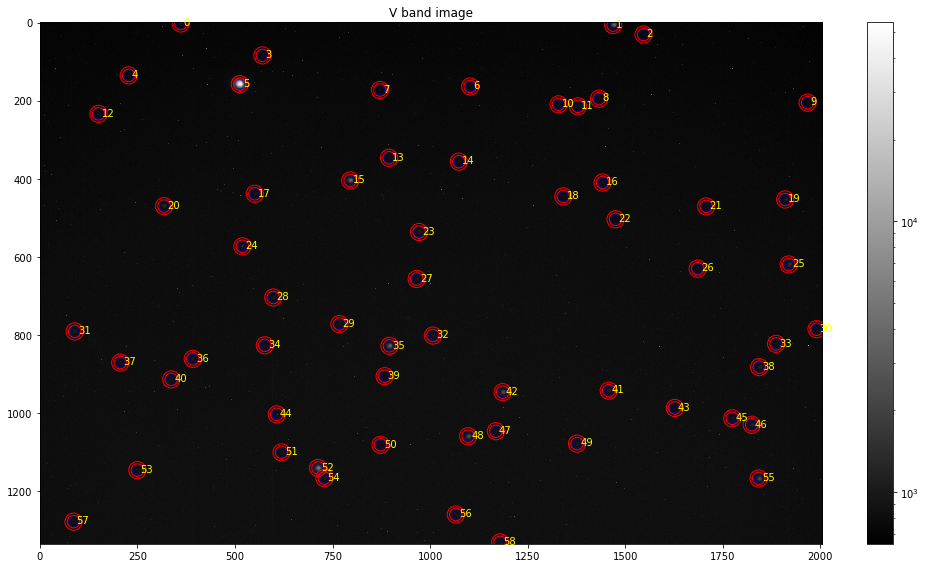

In [322]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)

im = ax.imshow(data, cmap='gray', origin='upper', norm=LogNorm(), interpolation='nearest')
apertures.plot(color='blue', lw=1, alpha=0.5)
annulus_apertures.plot(color='red', lw=1)

#ax.set_xlim([0,1000])
#ax.set_ylim([500,1250])

for i,p in enumerate(positions):
    ax.text(p[0]+8,p[1]+5,i, color="yellow")

fig.colorbar(im, ax=ax, pad=0.04)

t = ax.set_title("V band image".format(hdr['filter'])) ###ask about this if V or B band image

In [323]:
positions_B = np.transpose((sources_B['xcentroid'], sources_B['ycentroid']))
apertures_B = CircularAperture(positions_B, r=12.)

annulus_apertures_B = CircularAnnulus(positions_B, r_in=16, r_out=22)
annulus_masks_B = annulus_apertures.to_mask(method='center')

norm_B = ImageNormalize(interval=AsymmetricPercentileInterval(0,85), stretch=LinearStretch(),clip=True)

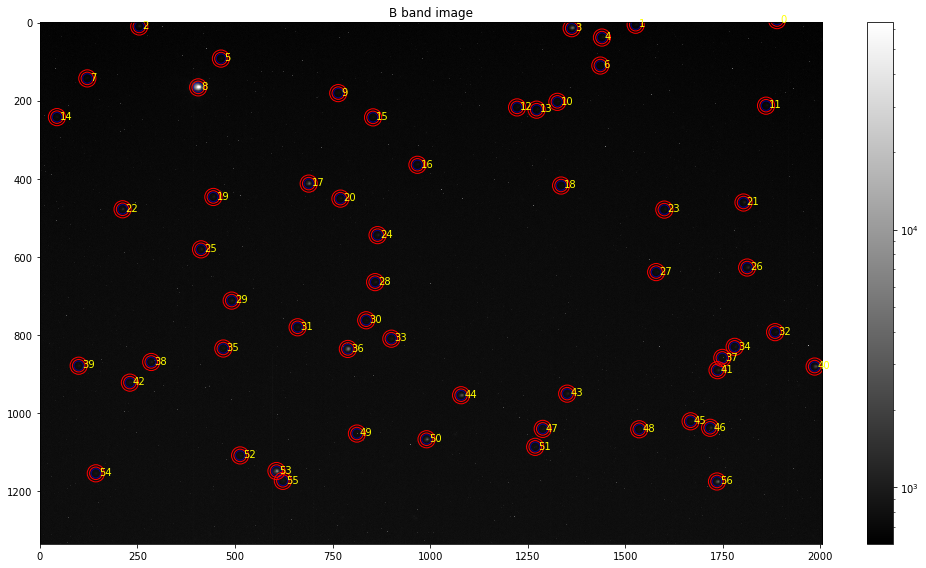

In [298]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)

im = ax.imshow(data_B, cmap='gray', origin='upper', norm=LogNorm(), interpolation='nearest') #change origin to 'upper' to flip image
apertures_B.plot(color='blue', lw=1, alpha=0.5)
annulus_apertures_B.plot(color='red', lw=1)

#ax.set_xlim([0,1000])
#ax.set_ylim([500,1250])

for i,p in enumerate(positions_B):
    ax.text(p[0]+8,p[1]+5,i, color="yellow")

fig.colorbar(im, ax=ax, pad=0.04)

t = ax.set_title("B band image".format(hdr_B['filter']))

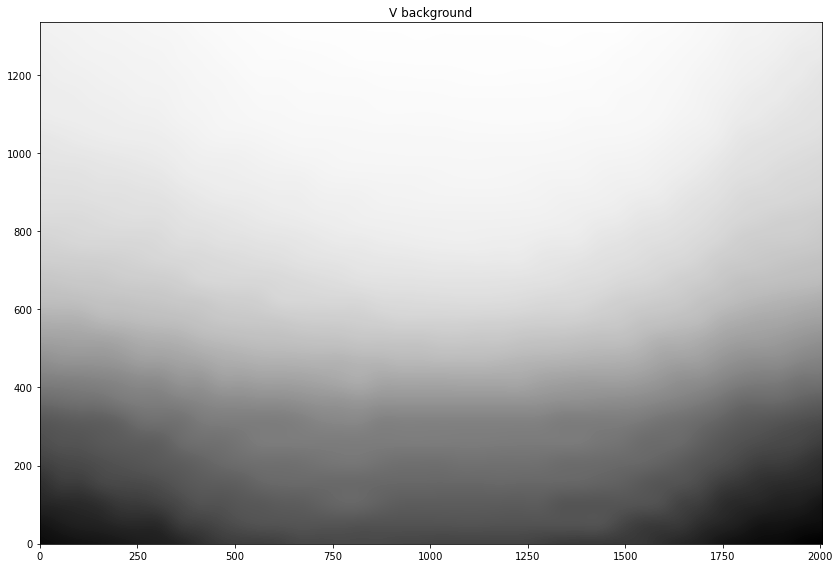

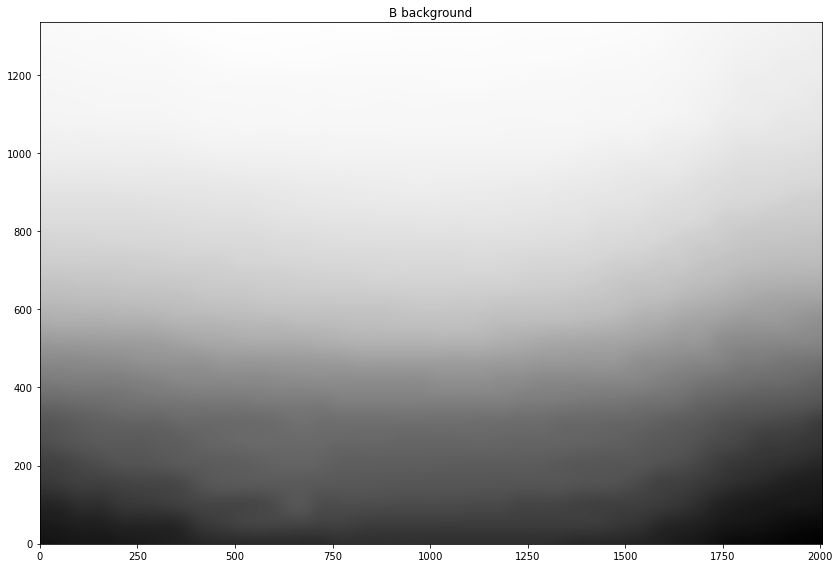

In [299]:
from photutils import Background2D, MedianBackground, SExtractorBackground
from astropy.stats import SigmaClip

sigma_clip = SigmaClip(sigma=5.)
bkg_estimator = SExtractorBackground()
bkg = Background2D(data, (50, 50), filter_size=(12, 12),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)
t = ax.set_title("V background")

ax.imshow(bkg.background, origin='lower', cmap='Greys_r', interpolation='nearest')
fig.savefig('background.png',bbox_inches="tight")

# now blue
bkg_B = Background2D(data_B, (50, 50), filter_size=(12, 12),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)
t = ax.set_title("B background")
ax.imshow(bkg_B.background, origin='lower', cmap='Greys_r', interpolation='nearest')



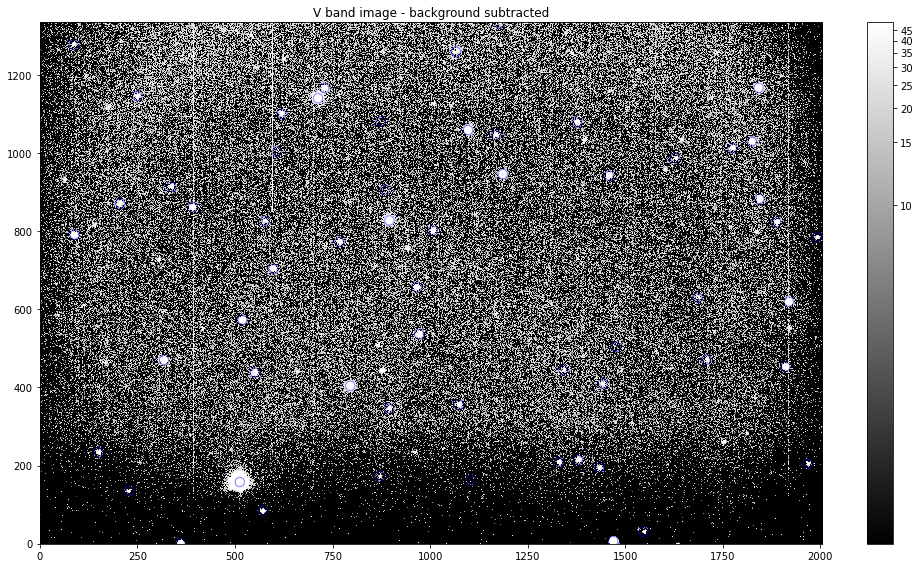

In [300]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)

norm = ImageNormalize(data - bkg.background,interval=AsymmetricPercentileInterval(65,99.), stretch=LogStretch(),clip=True)

im = ax.imshow(data - bkg.background, norm=norm, origin='lower', cmap='gray', interpolation='nearest')
apertures.plot(color='blue', lw=1, alpha=0.5)
fig.colorbar(im, ax=ax, pad=0.04)
t = ax.set_title("V band image - background subtracted")

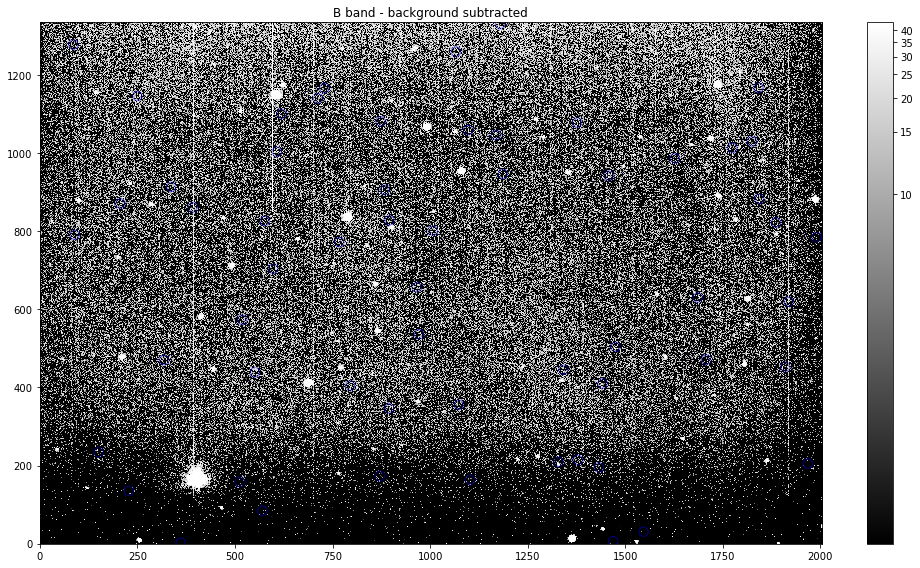

In [301]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)

norm = ImageNormalize(data_B - bkg_B.background,interval=AsymmetricPercentileInterval(65,99.), stretch=LogStretch(),clip=True)

im = ax.imshow(data_B - bkg_B.background, norm=norm, origin='lower', cmap='gray', interpolation='nearest')
apertures.plot(color='blue', lw=1, alpha=0.5)
fig.colorbar(im, ax=ax, pad=0.04)
t = ax.set_title("B band - background subtracted")

In [302]:
from photutils import aperture_photometry

In [303]:
apers = [apertures, annulus_apertures]
phot_table = aperture_photometry(data-bkg.background, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output

apers_B = [apertures_B, annulus_apertures_B]
phot_table_B = aperture_photometry(data_B-bkg_B.background, apers_B)
for col in phot_table_B.colnames:
    phot_table_B[col].info.format = '%.8g'  # for consistent table output

In [304]:
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 360.90816 2.1913521      21443.251     -10351.938
  2 1469.0448 6.4620251      266325.71     -9974.3558
  3 1546.8353 30.582896     -420.08958     -16527.483
  4 570.27108 84.047197      8053.4989     -13309.379
  5 227.62156 135.27659      30.390686     -11955.505
  6 512.10019 157.82546      5013892.1      145983.47
  7 1102.7014 163.71686     -3540.7884      -8100.235
  8 871.26036 172.79355      1142.9991     -7777.8153
  9 1432.6755 194.93327      7787.1536     -4071.6846
 10  1967.114 205.06922      2144.7268      -15171.33
...       ...       ...            ...            ...
 50 1376.2837  1078.798      17500.447      2433.8991
 51 872.94531 1081.8409      1594.8736      1328.2869
 52 619.27059 1101.2273       12390.37      3634.8847
 53 712.66387 1141.0643       400357.2      14373.758
 54 249.65446 1146.8005     

In [305]:
print(phot_table_B)

 id  xcenter   ycenter   aperture_sum_0 aperture_sum_1
       pix       pix                                  
--- --------- ---------- -------------- --------------
  1 1888.7305 -6.3890021      1137.4951     -8038.9434
  2 1526.5874  5.4594409     -1411.9014     -10689.829
  3 254.57035  9.9539959      10122.531      -11072.62
  4  1362.576  14.377348      146188.78     -11178.845
  5  1440.133   38.30616     -2226.9027     -14453.125
  6  463.8659  92.207911     -686.11465     -10796.233
  7 1436.0299   110.0619     -3448.4464      -7611.994
  8 121.52312  143.01362     -3446.8595     -12622.461
  9 405.58523  165.92845      4436958.4      83158.683
 10  764.4955  180.69389        150.868     -4978.0749
...       ...        ...            ...            ...
 48 1288.4238   1041.057      5934.7614      1024.2039
 49 1535.6188  1042.0381      4980.9735      849.69595
 50 812.33248  1052.9818      2922.5824      2025.5008
 51 990.74475  1067.6274      102798.21      3388.0742
 52 1269.1

In [306]:
bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area
bkg_mean_B = phot_table_B['aperture_sum_1'] / annulus_apertures_B.area

In [307]:
# V
bkg_sum = bkg_mean * apertures.area
final_sum = phot_table['aperture_sum_0'] - bkg_sum

phot_table['residual_aperture_sum'] = final_sum
phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output

phot_table['instrument_mag'] = -2.5 * np.log10(phot_table['residual_aperture_sum'] / hdr['exptime'])

print(phot_table['residual_aperture_sum','instrument_mag'])

residual_aperture_sum instrument_mag
--------------------- --------------
            27981.317     -7.4243672
            272625.31     -9.8961123
            10018.321     -6.3091842
            16459.422     -6.8482333
            7581.2361     -6.0065469
              4921692     -13.037483
            1575.1495     -4.3005013
            6055.3035     -5.7625367
            10358.744     -6.3454646
            11726.619     -6.4801289
                  ...            ...
            147813.52     -9.2314823
            15963.248         -6.815
             755.9555     -3.5034374
            10094.653     -6.3174254
            391279.04     -10.288413
            8349.4721     -6.1113444
             16259.96     -6.8349955
            145331.35     -9.2130951
            15952.579     -6.8142742
            6026.2764     -5.7573195
             4421.862     -5.4212098
Length = 59 rows


In [308]:
# B
bkg_sum_B = bkg_mean_B * apertures_B.area
final_sum_B = phot_table_B['aperture_sum_0'] - bkg_sum_B

phot_table_B['residual_aperture_sum'] = final_sum_B
phot_table_B['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output

phot_table_B['instrument_mag'] = -2.5 * np.log10(phot_table_B['residual_aperture_sum'] / hdr_B['exptime'])

print(phot_table_B['residual_aperture_sum','instrument_mag'])

residual_aperture_sum instrument_mag
--------------------- --------------
            6214.7225     -5.7907512
            5339.5697     -5.6259625
            17115.764     -6.8906876
             153249.1     -9.2706917
             6901.387     -5.9045378
            6132.5586     -5.7763011
            1359.1288     -4.1403484
             4525.221     -5.4462963
            4384437.2     -12.911981
            3294.9153     -5.1018075
                  ...            ...
            23386.061     -7.2295896
            5287.8958     -5.6154041
            4444.3235      -5.426711
            1643.3187     -4.3465014
            100658.37     -8.8143216
            6420.7308      -5.826158
            6693.7359     -5.8713683
            293036.85     -9.9745025
            7257.8282     -5.9592136
            7724.8026     -6.0269153
            110026.61     -8.9109411
Length = 57 rows


In [309]:
# We will choose source 47 as our comparison source and look up the star and its magnitude
# on Simbad.  From there we can do relative photometry:
# m1 - m2 = -2.5 log (F_1/F_2)
# m2 & F_2 will be for our comparison star.
#
# Source 47 is Tycho 2 2832-642-1
# V = 11.77
# B = 12.27
#
ref_V = 5 ###choose reference
F2_V = phot_table['residual_aperture_sum'][ref_V]
m2_V = 7.97 ###reference mag

m1_V = -2.5 * np.log10(phot_table['residual_aperture_sum']/F2_V) + m2_V

## Reference Star: HD 20163

In [310]:
ourStar = 35
ourStarName = 'HD 275115'
ourStarLitV = 11.31

print("{} V: {:.2f} (lit V = {:.2f})".format(ourStarName,m1_V[ourStar],ourStarLitV))

HD 275115 V: 11.11 (lit V = 11.31)


# Now the B magnitude

In [311]:
ourStar_B = 36
ourStarLitB = 11.61

In [312]:
ref_B = 8
F2_B = phot_table_B['residual_aperture_sum'][ref_B]
m2_B = 8.17

m1_B = -2.5 * np.log10(phot_table_B['residual_aperture_sum']/F2_B) + m2_B

In [313]:

print("{} B: {:.2f} (lit B = {:.2f})".format(ourStarName,m1_B[ourStar_B],ourStarLitB))

HD 275115 B: 11.36 (lit B = 11.61)


# Limit to counts > 1000 in apertures. Then try to sync up the numbers. 

In [314]:
minCounts = 1000
goodV = (phot_table['aperture_sum_0'] > 1000)
goodB = (phot_table_B['aperture_sum_0'] > 1000)

phot_table[goodV]

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,residual_aperture_sum,instrument_mag
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,360.90816,2.1913521,21443.251,-10351.938,27981.317,-7.4243672
2,1469.0448,6.4620251,266325.71,-9974.3558,272625.31,-9.8961123
4,570.27108,84.047197,8053.4989,-13309.379,16459.422,-6.8482333
6,512.10019,157.82546,5013892.1,145983.47,4921692,-13.037483
8,871.26036,172.79355,1142.9991,-7777.8153,6055.3035,-5.7625367
9,1432.6755,194.93327,7787.1536,-4071.6846,10358.744,-6.3454646
10,1967.114,205.06922,2144.7268,-15171.33,11726.619,-6.4801289
11,1329.0554,209.42961,8035.3704,-2099.9879,9361.6785,-6.2355812


In [315]:
phot_table_B[goodB]

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,residual_aperture_sum,instrument_mag
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,1888.7305,-6.3890021,1137.4951,-8038.9434,6214.7225,-5.7907512
3,254.57035,9.9539959,10122.531,-11072.62,17115.764,-6.8906876
4,1362.576,14.377348,146188.78,-11178.845,153249.1,-9.2706917
9,405.58523,165.92845,4436958.4,83158.683,4384437.2,-12.911981
11,1325.9846,203.05363,2998.7335,-2623.5545,4655.7153,-5.4771629
12,1860.6591,212.89544,3668.4446,-6622.2643,7850.9273,-6.0444993
13,1222.7123,217.31462,3147.6894,-2892.6248,4974.6103,-5.5490945
14,1272.7167,223.10659,3968.4347,-1103.2726,4665.2385,-5.4793815


# Other Sources (14 sources)


In [316]:
vb_pairs = [52,53], [48,50], [42,44], [1,3], [20,22], [15,17], [19,21], [25,26], [55,56], [41,43], [23,24], [27,28], [46,46], [32,33], [36,38], [37,39], [35,36], [5,8]


def rel_mag(flux, ref_flux, ref_mag):
    return -2.5*np.log10(flux/ref_flux) + ref_mag

# Plot HR Diagram

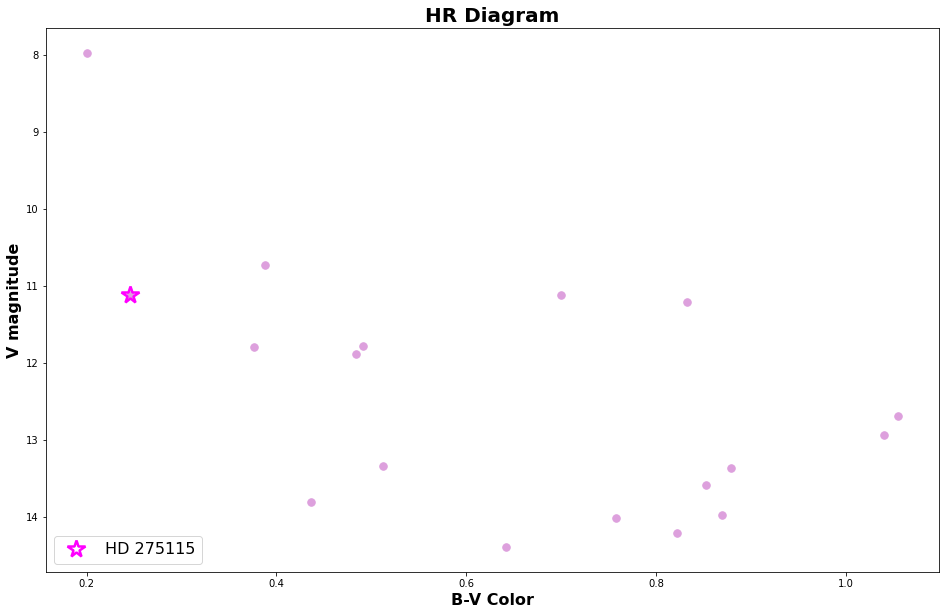

In [325]:
fig, ax = plt.subplots(1, 1, figsize=(16,10)) #(1, 1, figsize=(16,10), tight_layout=True)

t = ax.set_title("HR Diagram", fontweight='bold', fontsize=20)
t = ax.set_xlabel("B-V Color", fontweight='bold', fontsize=16)
t = ax.set_ylabel("V magnitude", fontweight='bold', fontsize=16)
t = ax.invert_yaxis()


for Vidx, Bidx in vb_pairs[:]:
    V = rel_mag(phot_table['residual_aperture_sum'][Vidx], F2_V, m2_V)
    B = rel_mag(phot_table_B['residual_aperture_sum'][Bidx], F2_B, m2_B)
              
    ax.plot(B-V, V, marker='.', markersize='15', color="plum", linewidth=1)
    

    if Vidx == ourStar:
        ax.plot(B-V, V, marker='*', markersize=18, linestyle='none', markeredgecolor='magenta', markerfacecolor='none', markeredgewidth=2.5, label=ourStarName)

        
t = ax.legend(loc="lower left", fontsize=16)

plt.show()


# Questions

Get relative V magnitudes for your star and all other stars in your field (brighter than some limiting magnitude that you choose...state the reasons for your choice).  Plot the distribution of V magnitudes that you find and comment on how that distribution looks and whether or not the V magnitude of your primary target agrees with literature values for that star. In addition, using either your field or some other that has both B & V images, calculate the B-V colors and V magnitudes of at least 15 sources and plot them in an HR diagram.  Discuss any interesting features you might see in your HR diagram (i.e. does it contain only main-sequence looking stars, or do some lie off in other parts of the diagram).  Remember to clearly label your plots, and check out the photometry notebook for how to perform differential photometry on the stars in an image.

________________________________________________________________________________________________________

As far as the pairs of stars that I chose, I looked for those that were visible to me in both the V and B band images. I would agree that the V magnitude of my star corresponds to its location on the y-axis very close to 11 mag given that its V mag is 11.31. The only concern I have is with respect to my color axis. I worked with Dilpreet and we used the same star and reference star, but came out with very different results. I think it may have been a result of differences in the staturation of our V and B band images. Additionally, there could be variation in the sources we chose and the aperature size that fit best with our images. But I will say the fact that our reference star and significantly brightest star in the image shows up in the very top left corresponding with the location of high V mag and low B-V color values of blue giants. This is slighlty reassuring that I did at least one thing right. 

I do not see any clear features of a traditional HR Diagram. My stars seem scattered, although I am going to reach and say there is some semblance of a main sequence diagonal from the topleft to the bottom middle of the graph. 